In [2]:
import pandas as pd
import xml.etree.ElementTree as ET
import glob, os
import numpy as np

In [3]:
from __future__ import print_function
import numpy as np

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import RegexpTokenizer

/home/ana/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ana/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ana/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ana/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/

# Read data

In [4]:
datadir_T1 = '/home/ana/eRisk/data/eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/data/'
labels_file_T1 = '/home/ana/eRisk/data/eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/golden_truth.txt'

In [5]:
labels_T1 = pd.read_csv(labels_file_T1, delimiter=' ', names=['subject', 'label'])

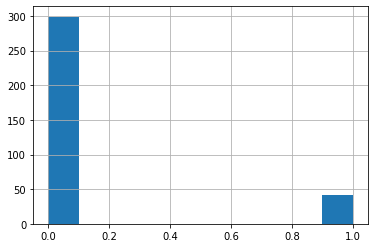

In [6]:
labels_T1.label.hist()

In [7]:
labels_T1 = labels_T1.set_index('subject')
labels_T1

,label
subject,
subject671,1
subject9917,1
subject6238,1
subject8581,1
subject7238,1
...,...
subject2182,0
subject9829,0
subject3270,0


## Read text

In [8]:
writings = []
for subject_file in os.listdir(datadir_T1):
    print(subject_file)
    with open(os.path.join(datadir_T1, subject_file)) as sf:
        contents = sf.read()
        root = ET.fromstring(contents)
        try:
            subject = root.findall('ID')[0].text
        except Exception:
            print('Cannot extract ID', contents[:500], '\n-------\n')        
        for w in root.iter('WRITING'):
            subject_writings = {'subject': subject}
            for title in w.findall('TITLE'):
                subject_writings['title'] = title.text
            for text in w.findall('TEXT'):
                subject_writings['text'] = text.text
            for date in w.findall('DATE'):
                subject_writings['date'] = date.text
            writings.append(subject_writings)
            # TODO: Date



subject8292.xml
subject6644.xml
subject7982.xml
subject9260.xml
subject9918.xml
subject4284.xml
subject9829.xml
subject7661.xml
subject8361.xml
subject4831.xml
subject2181.xml
subject9077.xml
subject2922.xml
subject2238.xml
subject4513.xml
subject269.xml
subject2678.xml
subject9197.xml
subject4143.xml
subject2605.xml
subject4226.xml
subject7627.xml
subject5150.xml
subject4510.xml
subject2182.xml
subject280.xml
subject1105.xml
subject187.xml
subject8001.xml
subject9285.xml
subject2621.xml
subject4414.xml
subject2685.xml
subject9961.xml
subject8065.xml
subject8225.xml
subject6866.xml
subject9949.xml
subject1507.xml
subject8329.xml
subject9411.xml
subject7857.xml
subject1545.xml
subject9811.xml
subject5000.xml
subject4843.xml
subject569.xml
subject51.xml
subject9156.xml
subject6453.xml
subject1210.xml
subject5528.xml
subject1485.xml
subject5935.xml
subject4527.xml
subject3301.xml
subject4074.xml
subject6093.xml
subject2088.xml
subject8990.xml
subject6459.xml
subject7830.xml
subject8395.xm

In [9]:
writings_df = pd.DataFrame(writings)

In [10]:
writings_df

,subject,title,date,text
0,subject8292,If anyone could help with which sub to put thi...,2016-08-02 09:22:12,NaN
1,subject8292,I'm literally never gonna stop waiting...,2016-08-05 09:35:55,NaN
2,subject8292,This is a really interesting study! Makes sens...,2016-08-05 21:36:24,NaN
3,subject8292,The only thing Frank is building ...,2016-08-07 23:35:23,"... Is hype. Think about it, every time he wor..."
4,subject8292,Mostly always me during this whole charade,2016-08-09 08:39:41,NaN
...,...,...,...,...
170693,subject217,NaN,2018-08-19 11:29:21,"this is my personal experience ,it may not ref..."
170694,subject217,NaN,2018-08-19 16:17:34,stop looking at 20 million saudis as one entit...
170695,subject217,NaN,2018-08-19 20:00:31,i am aware of stats now and then. i was just s...
170696,subject217,WHAT DID YOU SAY TO ME?,2018-08-20 10:54:11,NaN


In [11]:
writings_df['label'] = writings_df['subject'].apply(
    lambda s: labels_T1.loc[s, 'label'])

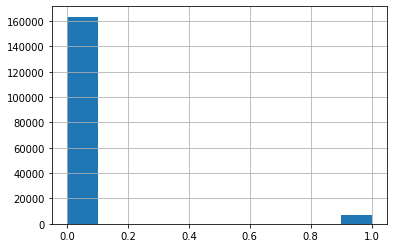

In [12]:
writings_df.label.hist()

In [13]:
tokenizer = RegexpTokenizer(r'\w+')

def tokenize(t):
    return tokenizer.tokenize(t.lower())

In [14]:
tokenize("I wasn't ready to leave! buh-buw(dd). Sasa .")

['i', 'wasn', 't', 'ready', 'to', 'leave', 'buh', 'buw', 'dd', 'sasa']

In [15]:
writings_df['tokenized_title'] = writings_df['title'].apply(lambda t: tokenize(t) if type(t)==str else np.nan)
writings_df['title_len'] = writings_df['tokenized_title'].apply(lambda t: len(t) if type(t)==list else np.nan)
writings_df['tokenized_text'] = writings_df['text'].apply(lambda t: tokenize(t) if type(t)==str else np.nan)
writings_df['text_len'] = writings_df['tokenized_text'].apply(lambda t: len(t) if type(t)==list else np.nan)

In [16]:
writings_df.text_len.describe()

count    127941.000000
mean         32.268929
std          82.590713
min           0.000000
25%           6.000000
50%          13.000000
75%          31.000000
max        7201.000000
Name: text_len, dtype: float64

In [17]:
writings_df.title_len.describe()

count    49762.000000
mean        10.699771
std          9.282454
min          0.000000
25%          4.000000
50%          8.000000
75%         14.000000
max        149.000000
Name: title_len, dtype: float64

In [18]:
writings_df.groupby('subject').mean()

,label,title_len,text_len
subject,,,
subject0,0,20.285714,31.711712
subject1027,0,7.769231,1.190476
subject1055,0,16.666667,79.983193
subject1064,1,13.000000,68.410256
subject1089,0,9.823529,13.254902
...,...,...,...
subject9917,1,8.983607,95.806897
subject9918,0,5.000000,11.865269
subject992,0,5.872928,19.876190


In [19]:
writings_df[(~writings_df['text_len'].isna()) & (writings_df['text_len'] > 100)]


,subject,title,date,text,label,tokenized_title,title_len,tokenized_text,text_len
122,subject8292,Okay friends so I messed up and posted to do a...,2017-04-25 22:37:57,"Sorry for that, I truly didn't think it was go...",0,"[okay, friends, so, i, messed, up, and, posted...",34.0,"[sorry, for, that, i, truly, didn, t, think, i...",120.0
390,subject8292,NaN,2017-09-16 06:29:13,You've got plenty of time to fix that. You can...,0,NaN,NaN,"[you, ve, got, plenty, of, time, to, fix, that...",104.0
498,subject8292,NaN,2017-11-24 01:33:22,"LCD, Glass animals, Kendrick, The Weeknd, Jack...",0,NaN,NaN,"[lcd, glass, animals, kendrick, the, weeknd, j...",127.0
752,subject8292,Getting that coachella bod,2018-01-09 00:54:06,First I want to say whatever skin is your skin...,0,"[getting, that, coachella, bod]",4.0,"[first, i, want, to, say, whatever, skin, is, ...",149.0
904,subject8292,NaN,2018-03-12 17:14:03,Not the same but me and my wife saw a man and ...,0,NaN,NaN,"[not, the, same, but, me, and, my, wife, saw, ...",151.0
...,...,...,...,...,...,...,...,...,...
170652,subject217,NaN,2018-05-28 12:23:00,/r/keto /r/ketorecipes /r/ketodessert all are ...,0,NaN,NaN,"[r, keto, r, ketorecipes, r, ketodessert, all,...",197.0
170653,subject217,NaN,2018-05-28 12:32:36,its okay dont worry . as long as you don't exc...,0,NaN,NaN,"[its, okay, dont, worry, as, long, as, you, do...",109.0
170662,subject217,NaN,2018-06-20 00:33:57,the national number is :1919 here are more com...,0,NaN,NaN,"[the, national, number, is, 1919, here, are, m...",115.0
170693,subject217,NaN,2018-08-19 11:29:21,"this is my personal experience ,it may not ref...",0,NaN,NaN,"[this, is, my, personal, experience, it, may, ...",153.0


# Recurrent NN

In [20]:
max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
batch_size = 32
embedding_dim = 100

In [21]:
from collections import Counter
def load_erisk_data(writings_df, voc_size, train_prop=0.7, min_post_len=3, min_word_len=1):
    print("Loading data...")
    vocabulary = {}
    word_freqs = Counter()
    for words in writings_df[~writings_df['tokenized_text'].isna()].tokenized_text:
        word_freqs.update(words)
    i = 1
    for w, f in word_freqs.most_common(voc_size-1):
        if len(w) < min_word_len:
            continue
        vocabulary[w] = i
        i += 1
    data_train = []
    data_test = []
    labels_train = []
    labels_test = []
    # TODO: shuffle?
    all_subjects = list(set(writings_df.subject))
    training_subjects_size = int(len(all_subjects) * train_prop)
    training_subjects = all_subjects[:training_subjects_size]
    training_rows = writings_df[writings_df['subject'].isin(training_subjects)]
    test_rows = writings_df[~writings_df['subject'].isin(training_subjects)]
    for row in training_rows[~training_rows['tokenized_text'].isna()].itertuples():
        words = row.tokenized_text
        if not words or len(words)<min_post_len:
            continue
        label = row.label
        # Using 0 for OOV token
        data_train.append([vocabulary.get(w, 0) for w in words])
        labels_train.append(label)
    for row in test_rows[~test_rows['tokenized_text'].isna()].itertuples():
        words = row.tokenized_text
        if not words or len(words)<min_post_len:
            continue
        label = row.label
        # Using 0 for OOV token
        data_test.append([vocabulary.get(w, 0) for w in words])
        labels_test.append(label)
        
    return (data_train, labels_train), (data_test, labels_test), vocabulary

In [22]:
(x_train, y_train), (x_test, y_test), voc = load_erisk_data(writings_df, voc_size=max_features)

Loading data...


In [23]:
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

84322 train sequences
30620 test sequences


In [24]:
print(pd.Series(y_train).sum(), "positive training examples")
print(pd.Series(y_test).sum(), "positive test examples")

4571 positive training examples
1805 positive test examples


In [25]:
len([x[0] for x in x_train if len(x)<3])

0

In [26]:
voc_index = {w: i for i, w in voc.items()}
voc_index

{1: 'the',
 2: 'i',
 3: 'to',
 4: 'a',
 5: 'and',
 6: 'of',
 7: 'it',
 8: 'that',
 9: 'you',
 10: 'in',
 11: 'is',
 12: 's',
 13: 'for',
 14: 't',
 15: 'this',
 16: 'on',
 17: 'but',
 18: 'with',
 19: 'my',
 20: 'was',
 21: 'be',
 22: 'have',
 23: '8217',
 24: 'not',
 25: 'are',
 26: 'they',
 27: 'as',
 28: 'if',
 29: 'so',
 30: 'just',
 31: 'like',
 32: 'can',
 33: 'he',
 34: 'or',
 35: 'we',
 36: 'at',
 37: 'what',
 38: 'me',
 39: 'm',
 40: 'com',
 41: 'from',
 42: 'your',
 43: 'do',
 44: 'all',
 45: 'about',
 46: 'there',
 47: 'an',
 48: 'one',
 49: 'would',
 50: 'out',
 51: 'don',
 52: 'more',
 53: 'up',
 54: 'get',
 55: 'people',
 56: 'https',
 57: 'when',
 58: 'gt',
 59: 'will',
 60: 'no',
 61: 'by',
 62: 'them',
 63: 'how',
 64: 'has',
 65: 'think',
 66: 're',
 67: 'know',
 68: 'some',
 69: 'time',
 70: 'because',
 71: 'their',
 72: 'www',
 73: 'his',
 74: 'who',
 75: 'she',
 76: 'had',
 77: 'really',
 78: 'here',
 79: 'good',
 80: 've',
 81: 'also',
 82: 'r',
 83: 'now',
 84: '

In [27]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

Pad sequences (samples x time)


In [28]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

x_train shape: (84322, 100)
x_test shape: (30620, 100)


In [29]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([0.52865795, 9.22358346])

In [43]:
def load_embeddings(path, embedding_dim, voc):
    # random matrix with mean value = 0
    embedding_matrix = np.random.random((len(voc)+1, embedding_dim)) - 0.5
#     embedding_matrix = np.zeros((len(voc)+1, embedding_dim))

    f = open(path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_i = voc.get(word)
        if word_i is not None:
            embedding_matrix[word_i] = coefs
    f.close()

    print('Total %s word vectors.' % len(embedding_matrix))

 
    return embedding_matrix

embedding_matrix = load_embeddings('/home/ana/resources/glove.6B/glove.6B.100d.txt', embedding_dim, voc)

Total 20000 word vectors.


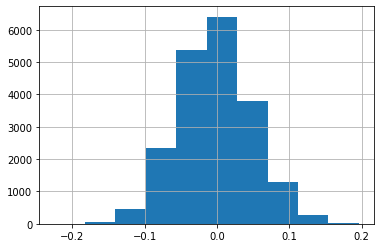

In [44]:

pd.Series(embedding_matrix.mean(axis=1)).hist()

In [45]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=maxlen, 
                    weights=[embedding_matrix], trainable=True))


Instructions for updating:
Colocations handled automatically by placer.


In [46]:
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [47]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [48]:
# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy',
              metrics=['binary_accuracy', f1_m, precision_m, recall_m])

In [ ]:
%%time
print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=7, class_weight={0:0.5, 1:9},
          validation_data=[x_test, y_test],
                   workers=4)

Train...
Train on 84322 samples, validate on 30620 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/7
  160/84322 [..............................] - ETA: 58:18 - loss: 0.6547 - binary_accuracy: 0.8438 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00  

In [ ]:
model.save('models/simple_lstm_emb1')

In [ ]:
history.history

In [154]:
predictions = model.predict(x_test)

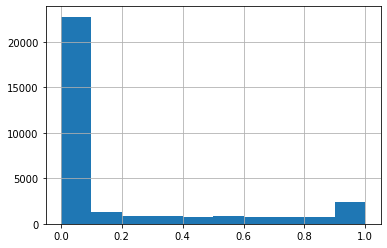

In [158]:
pd.Series(predictions.flatten()).hist()

In [156]:
sum(predictions>0.5)

array([5424])

In [157]:
sum(predictions<0.5)

array([26518])

In [150]:
class_weights

array([0.53592644, 7.45866283])